# Natural Gas Prediction Model

## Purpose: 
To predict gas prices using both a Linear Regression Model and a Sinusoidal Regression for contract evaluations.  Then compare which gives a more accurate analysis on Natural Gas Prices dataset from the Henry Hub Distribution Hub. 


## Bottom-Line Up Front

Sinusoidal Model assumes smooth symmetric pattern, the plot does not follow a perfect wave, the one hot encoding allows each month to have its own coefficient.

The model does no account for weather and economic events. Those feature will be added and ran through more advance Machine Learning models. 


In [35]:
# Install libraries
!python -m pip install --upgrade pip -q
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl -q
!pip install notebook -q
!pip install nbconvert -q
!pip install tabulate -q
!pip install xlrd -q
!pip install yfinance -q

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf

warnings.filterwarnings('ignore')

In [2]:
# import s&p 500 data from yfinance ticker ^GSPC with interval 1mo to fetch monthly data 
# fetch from 1997-2005 to match my natural gas data
sp500_data = yf.download('^GSPC', start='1997-01-01', end='2025-12-31', interval='1mo')['Close']
sp500_data.reset_index(inplace=True)
sp500_data = sp500_data.rename(columns={'Date': 'Dates', '^GSPC': 'SP500_Close'})
sp500_data.head()


[*********************100%***********************]  1 of 1 completed


Ticker,Dates,SP500_Close
0,1997-01-01,786.159973
1,1997-02-01,790.820007
2,1997-03-01,757.119995
3,1997-04-01,801.340027
4,1997-05-01,848.280029


In [3]:
# Load the dataset
df = pd.read_excel('RNGWHHDm.xls', sheet_name='Data 1', skiprows=2)


In [4]:
df = pd.read_excel('RNGWHHDm.xls', sheet_name='Data 1', skiprows=2)
display(df.head())
display(df.tail())
print(df.info())

,Date,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
0,1997-01-15,3.45
1,1997-02-15,2.15
2,1997-03-15,1.89
3,1997-04-15,2.03
4,1997-05-15,2.25


,Date,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
343,2025-08-15,2.91
344,2025-09-15,2.97
345,2025-10-15,3.19
346,2025-11-15,3.79
347,2025-12-15,4.26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Date                                                        348 non-null    datetime64[ns]
 1   Henry Hub Natural Gas Spot Price (Dollars per Million Btu)  348 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.6 KB
None


In [5]:
# convert 'Dates' column to datetime and 'Prices' column to numeric
df.rename(columns={'Date': 'Dates', 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'Prices'}, inplace=True)
df['Dates'] = pd.to_datetime(df['Dates'])
df['Prices'] = pd.to_numeric(df['Prices'], errors='coerce')
display(df.head())

,Dates,Prices
0,1997-01-15,3.45
1,1997-02-15,2.15
2,1997-03-15,1.89
3,1997-04-15,2.03
4,1997-05-15,2.25


In [ ]:
display(df.head())

,Dates,Prices
0,1997-01-15,3.45
1,1997-02-15,2.15
2,1997-03-15,1.89
3,1997-04-15,2.03
4,1997-05-15,2.25


In [7]:
# Updata the dataframe to include s&p 500 data

df['Merge_Date'] = df['Dates'].dt.to_period('M')
sp500_data['Merge_Date'] = sp500_data['Dates'].dt.to_period('M')

df = pd.merge(df, sp500_data[['Merge_Date', 'SP500_Close']], on='Merge_Date', how='left')
df.drop(columns=['Merge_Date'], inplace=True)
display(df.head())
display(df.info())

,Dates,Prices,SP500_Close
0,1997-01-15,3.45,786.159973
1,1997-02-15,2.15,790.820007
2,1997-03-15,1.89,757.119995
3,1997-04-15,2.03,801.340027
4,1997-05-15,2.25,848.280029


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Dates        348 non-null    datetime64[ns]
 1   Prices       348 non-null    float64       
 2   SP500_Close  348 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.3 KB


None

## Methodology
### Linear Regression Model
- Load relevant libraries
- Import and format the data
- Create a time index by one hot encoding the month
- Split the model into test and training dataset chronologically by year, using the last year as the test year.
- After running the LinearRegression() function, get the model.coef[0] and the model.intercept and use it to calculate the price. 
- Create a function to determine the price
- Create a while-loop to prompt the user for a date and it should call the function and return the predicted date. 
- Plot the predicted prices amongst the actual prices and check for accuracy. 

In [8]:
# convert 'Dates' column to datetime
df['Dates'] = pd.to_datetime(df['Dates'])

# Clean up data and create time-based index and one-hot encoding the month
df['time_index'] = range(len(df))
df['Month'] = df['Dates'].dt.month
df = pd.get_dummies(df, columns=['Month']) # after encoding month, convert to 1 or 0 instead of true or false

In [10]:
# Split the data into features and target variable
X_Linear = df.drop(columns=['Prices']).astype(int)
y_Linear = df['Prices']

# split the data into training and testing sets
X_train_Linear = X_Linear[:324] # train on first 324 samples or 27 years of data
X_test_Linear = X_Linear[324:] # test on last 12 years of data
y_train_Linear = y_Linear[:324] # train on first 324 samples or 27 years of data
y_test_Linear = y_Linear[324:] # test on last 12 years of data
print(f'Training set size: {X_train_Linear.shape[0]} samples')
print(f'Testing set size: {X_test_Linear.shape[0]} samples')

# Build a linear regression model to predict natural gas prices
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_Linear, y_train_Linear)


Training set size: 324 samples
Testing set size: 24 samples


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [11]:
# Function to predict price based on date
def predict_price_linear(date):
    # change the date to the time index with 2020-10-31 as index 0
    date = pd.to_datetime(date)
    time_index = (date.year - 2020) * 12 + (date.month - 10)
    price = model.intercept_ + (model.coef_[0] * time_index) + model.coef_[date.month]
    return round(price, 2)

## Sinusoidal Regression Model 

## Methodology
### Sinusoidal Regression Model
- Convert everything into a numpy array
- Calculate trend line
- the y intercept
- calculate the sine and cosine coefficient
- Calculate the Amplitude and Phase shift
- Create a function that uses the sinusoidal Regression model to predict prices


In [12]:
# Convert Dates to datetime format in numpy array
prices = np.array(df['Prices'])
dates = np.array(df['Dates'])
sp_500_prices = np.array(df['SP500_Close'])
dates = pd.to_datetime(dates)

In [13]:
# Calculate trend line using Linear Regression to handle multiple variables

# convert dates to numerical format (days since epoch)
df['day_since_epoch'] = pd.to_datetime(df['Dates']).astype(np.int64) // 10**9 // 86400  # Convert to days since epoch

# Split the data into features and target variable
X = df[['day_since_epoch', 'SP500_Close']]
y = df['Prices']

# Split the data into train_test_split
X_train = X[:324] # train on first 324 samples or 27 years of data
X_test = X[324:] # test on last 12 years of data
y_train = y[:324] # train on first 324 samples or 27 years of data
y_test = y[324:] # test on last 12 years of data


model = LinearRegression()
model.fit(X_train, y_train)

# Print m1, m2, and b
m1_time = model.coef_[0]
m2_sp_500 = model.coef_[1]
b = model.intercept_

formula = f"Price = {m1_time:.6f} * Time_Index + {m2_sp_500:.6f} * SP500_Close + {b:.2f}"
print("Linear Regression Formula:")
print(formula)  


Linear Regression Formula:
Price = 0.000034 * Time_Index + -0.000465 * SP500_Close + 4.57


In [14]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Root Mean Squared Error (RMSE): 1.06


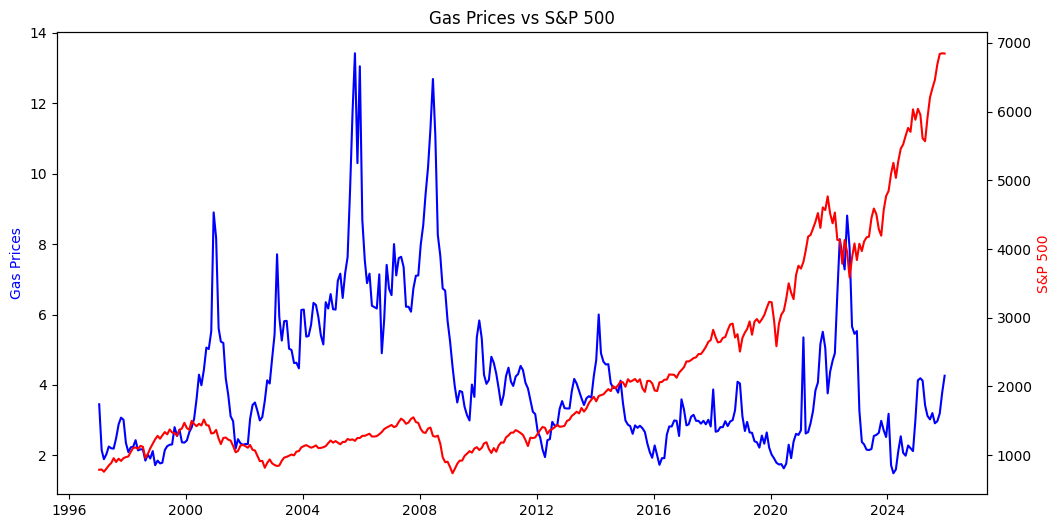

In [15]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df['Dates'], df['Prices'], 'b-', label='Gas Prices')
ax1.set_ylabel('Gas Prices', color='b')

ax2 = ax1.twinx()
ax2.plot(df['Dates'], df['SP500_Close'], 'r-', label='S&P 500')
ax2.set_ylabel('S&P 500', color='r')

plt.title('Gas Prices vs S&P 500')
plt.show()

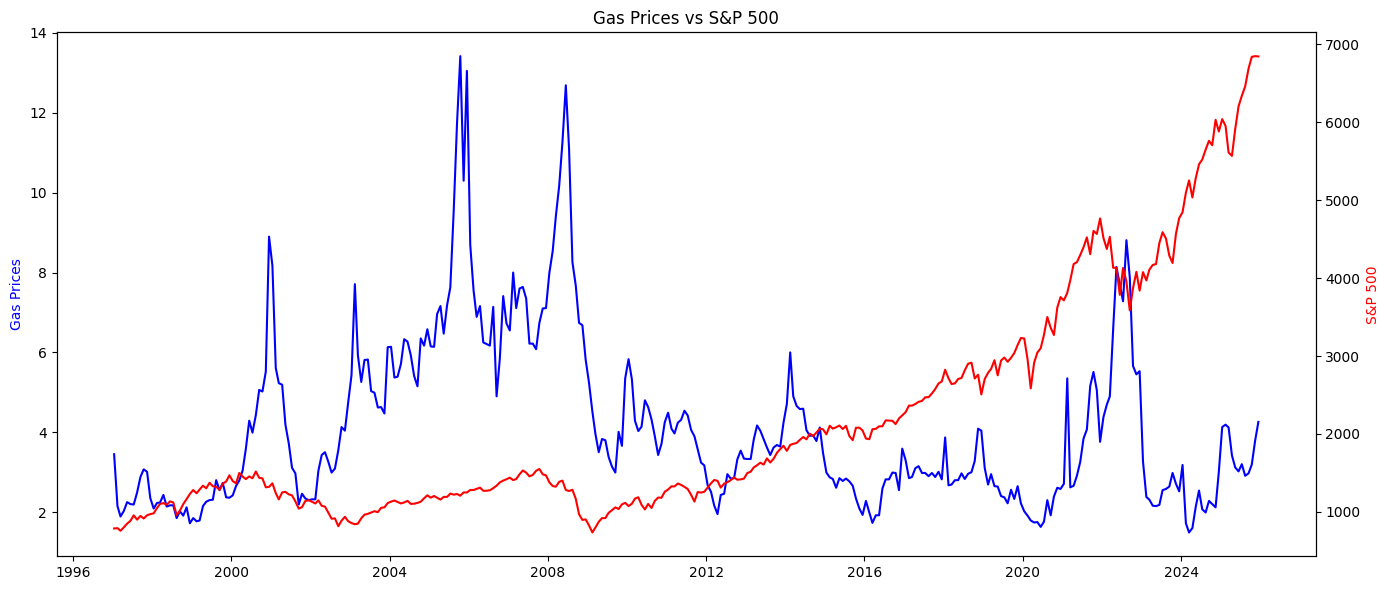

In [20]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(df['Dates'], df['Prices'], 'b-', label='Gas Prices')
ax1.set_ylabel('Gas Prices', color='b')

ax2 = ax1.twinx()
ax2.plot(df['Dates'], df['SP500_Close'], 'r-', label='S&P 500')
ax2.set_ylabel('S&P 500', color='r')

# Rotate x-axis labels 90 degrees
plt.xticks(rotation=90)

# Show more year labels (every year instead of every 4)

plt.title('Gas Prices vs S&P 500')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate sine(2π * days / 12) and cosine(2π * days / 12) components for seasonality
sine_time = np.sin(2 * np.pi * x/ 365.25)
cosine_time = np.cos(2 * np.pi * x / 365.25)

# calculate sine and cosine coefficients
u = np.sum(residuals * sine_time) / np.sum(sine_time**2)
w = np.sum(residuals * cosine_time) / np.sum(cosine_time**2)


In [ ]:
# Function to predict future prices

def predict_price_sinusoidal(user_input):
    # Convert user input date to ordinal
    date = pd.to_datetime(user_input).value //10**9 // 86400
    x = date
    sine_value = np.sin(2 * np.pi * x / 365.25)
    cosine_value = np.cos(2 * np.pi * x / 365.25)
    Price = ((m * x) + b) + ((u * sine_value) + (w * cosine_value))
    
    return Price
    

In [ ]:
# TEST THE FUNCTION
test_date = '2025-01-30'
predict_price_sinusoidal(test_date)

np.float64(3.4618724558464007)

In [ ]:
print(len(df))

348


## Model Comparisons: 

Compare the models to the actual data, and visualize how it compares. 

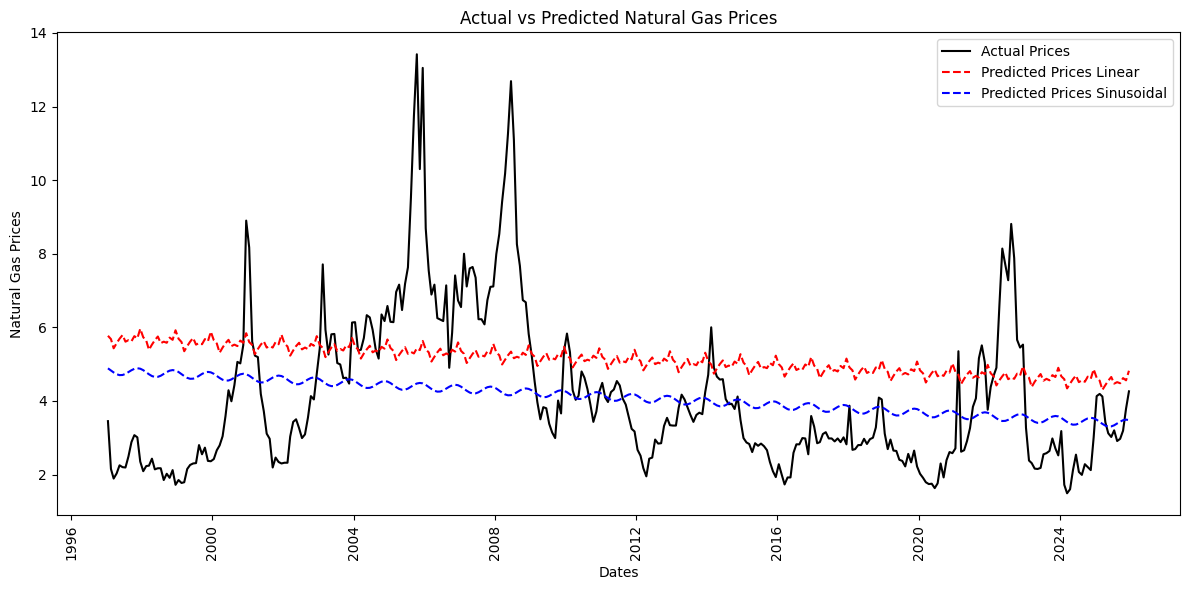

In [ ]:
# To check how the model compares to the actual data. 

predicted_all_sinusoidal = trend_line + ((u * sine_time)) + (w * cosine_time)
predicted_all_linear = np.array([predict_price_linear(date) for date in df['Dates']])

plt.figure(figsize=(12,6))
plt.plot(dates, y, label ='Actual Prices', color ='Black')
plt.plot(dates, predicted_all_linear, label ='Predicted Prices Linear', color ='red', linestyle='--')
plt.plot(dates, predicted_all_sinusoidal, label ='Predicted Prices Sinusoidal', color ='blue', linestyle='--')
plt.xlabel('Dates')
plt.ylabel('Natural Gas Prices')
plt.title('Actual vs Predicted Natural Gas Prices') 
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Check with one is better
error_sinusoidal = y - predicted_all_sinusoidal # get residual amount compared to actual prices
error_linear = y - predicted_all_linear

squared_errors_sinusoidal = error_sinusoidal ** 2 # square the errors
squared_errors_linear = error_linear ** 2   

mean_squared_error_sinusoidal = np.mean(squared_errors_sinusoidal) # find the mean of the squared errors
mean_squared_error_linear = np.mean(squared_errors_linear)  

rmse_sinusoidal = np.sqrt(mean_squared_error_sinusoidal) # find the root mean squared error which gives a dollar amount
rmse_linear = np.sqrt(mean_squared_error_linear)

print(f'RMSE Sinusoidal Model: {rmse_sinusoidal:.3f}')
print(f'RMSE Linear Model: {rmse_linear:.3f}')
if rmse_sinusoidal < rmse_linear:
    print(f'Sinusoidal Model performs better than Linear Model by {rmse_linear - rmse_sinusoidal:.3f} in RMSE')
else:
    print(f'Linear Model performs better than Sinusoidal Model by {rmse_sinusoidal - rmse_linear:.3f} in RMSE')

RMSE Sinusoidal Model: 2.069
RMSE Linear Model: 2.304
Sinusoidal Model performs better than Linear Model by 0.235 in RMSE


# Function To Calculate Contract Value

This is a function that returns the value of a contract based on:
- The injection date (YYYY-MM-DD)
- The withdrawal date (YYYY-MM-DD)
- The maximum the storage facility can hold (in millions of MMBtu)
- The volume purchased (in millions of MMBtu)
- The storage fee (in thousands, e.g., 100 = $100,000/month)
- The injection fee (in thousands per million MMBtu)
- The withdrawal fee (in thousands per million MMBtu)
- The transport rate each way (in thousands, e.g., 50 = $50,000)

## Example

# Buy 1 million MMBtu in June, sell in December
value = price_contract('2025-06-01', '2025-12-01', 5, 1, 100, 10, 10, 50)
print(f"Contract Value: ${value:,.2f}")
# Output: Contract Value: $690,000.00


In [ ]:
def price_contract(injection_date, withdrawal_date, max_volume_storage_capacity, volume, storage_rate, injection_rate, withdrawal_rate, transport_rate):
    # Step 1: Calculate the Buying Price at Injection Date
    injection_date = datetime.datetime.strptime(str(injection_date), '%Y-%m-%d')
    withdrawal_date = datetime.datetime.strptime(str(withdrawal_date), '%Y-%m-%d')
    buying_price = predict_price_sinusoidal(injection_date)

    if max_volume_storage_capacity < volume:
        print(f"Volume exceeds maximum storage capacity. {max_volume_storage_capacity} capacity will be used.")
        volume = max_volume_storage_capacity
    actual_volume = volume * 1e6 
    # Step 2: Calculate the Selling Price at Withdrawal Date
    selling_price = predict_price_sinusoidal(withdrawal_date)
    
    # Step 3: Calculate Total Storage Cost
    storage_cost = (((withdrawal_date - injection_date).days / 30)* (storage_rate * 1000))
    
    # Step 5: Calculate Total Transport Cost
    Total_Transport_cost  = (transport_rate*1000) * 2
    
    # Step 6: Calculate injection cost
    injection_cost = (injection_rate*1000) * volume
    
    # Step 7: Calculate withdrawal cost
    withdrawal_cost = (withdrawal_rate*1000) * volume
    
    # Step 8: Calculate Value
    Value = (selling_price * actual_volume) - (buying_price * actual_volume) - storage_cost - injection_cost - withdrawal_cost - Total_Transport_cost
    return Value

In [ ]:
# Test 1: Under max
value = price_contract('2025-06-01', '2025-12-01', 5, 1, 100, 10, 10, 50)
print(f"Contract Value: ${value:,.2f}")

# Test 2: Over max (should warn and cap at 5)
value = price_contract('2025-06-01', '2025-12-01', 5, 10, 100, 10, 10, 50)
print(f"Contract Value: ${value:,.2f}")

# Test 3: Exactly 5 (no cap needed)
value = price_contract('2025-06-01', '2025-12-01', 5, 5, 100, 10, 10, 50)
print(f"Contract Value: ${value:,.2f}")

Contract Value: $-560,000.00
Volume exceeds maximum storage capacity. 5 capacity will be used.
Contract Value: $40,000.00
Contract Value: $40,000.00


In [ ]:
while True:
    injection_date = input("Enter the injection date (YYYY-MM-DD)  (or 'q' to quit): ")
    if injection_date.lower() == 'q':
        break
    
    withdrawal_date = input("Enter the withdrawal date (YYYY-MM-DD)  (or 'q' to quit): ")
    if withdrawal_date.lower() == 'q':
        break
    max_volume_storage_capacity = (input("Enter the maximum volume storage capacity in million MMBtu (ex 10 for 10,000,000) or 'q' to quit: "))
    if max_volume_storage_capacity.lower() == 'q':
        break
    max_volume_storage_capacity = float(max_volume_storage_capacity)
    volume = (input("Enter the volume in million MMBtu (ex 1,2 for 1,000,000) or 'q' to quit: "))
    if volume.lower() == 'q':
        break
    volume = float(volume)
    storage_rate = (input("Enter the storage rate (for ex 100 for $100,000) or 'q' to quit: "))
    if storage_rate.lower() == 'q':
        break
    storage_rate = float(storage_rate)
    injection_rate = (input("Enter the injection rate (for ex 10 for $10,000 or 'q' to quit: "))
    if injection_rate.lower() == 'q':
        break
    injection_rate = float(injection_rate)
    withdrawal_rate = (input("Enter the withdrawal rate (for ex 10 for $10,000 or 'q' to quit: "))
    if withdrawal_rate.lower() == 'q':
        break
    withdrawal_rate = float(withdrawal_rate)
    transport_rate = (input("Enter the transport rate (for ex 5 for $5,000 or 'q' to quit: "))
    if transport_rate.lower() == 'q':
        break
    transport_rate = float(transport_rate)
    
    try:
        print(f"Contract Value: ${price_contract(injection_date, withdrawal_date, max_volume_storage_capacity, volume, storage_rate, injection_rate, withdrawal_rate, transport_rate):.2f}")
    except Exception as e:
        print(f"Error: {e}. Please enter a valid entry.")

## Future Improvement to Tests: 

- Try daily time index instead of monthly to see if i can improve accuracy. 